### **$Part$ $1$**

*This section details the methodology used to acquire, preprocess, and structure the dataset for the task of instruction-based object removal and image inpainting. The process transforms a dataset originally intended for object addition into a clean, well-organized corpus tailored to our specific modeling requirements.*

---

#### **$Load$  $Libraries$**

---

In [13]:
from datasets import load_dataset
import os
from IPython.display import display
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

---

#### $Load$ $Dataset$ 

---

In this part of the project, we stream the dataset from hugging-face:
* `https://huggingface.co/datasets/paint-by-inpaint/PIPE_Masks`

* `https://huggingface.co/datasets/paint-by-inpaint/PIPE/viewer/default/train`


In [2]:
# Use streaming = True to avoid full download
pipe = load_dataset("paint-by-inpaint/PIPE", split="train", streaming=True)
pipe_masks = load_dataset("paint-by-inpaint/PIPE_Masks", split="train", streaming=True)

In [3]:
pipe_masks.features 

{'mask': Image(mode=None, decode=True, id=None),
 'target_img_dataset': Value(dtype='string', id=None),
 'img_id': Value(dtype='string', id=None),
 'ann_id': Value(dtype='string', id=None)}

In [4]:
pipe.features 

{'source_img': Image(mode=None, decode=True, id=None),
 'target_img': Image(mode=None, decode=True, id=None),
 'Instruction_VLM-LLM': Value(dtype='string', id=None),
 'Instruction_Class': Value(dtype='string', id=None),
 'Instruction_Ref_Dataset': Value(dtype='string', id=None),
 'object_location': Value(dtype='string', id=None),
 'target_img_dataset': Value(dtype='string', id=None),
 'img_id': Value(dtype='string', id=None),
 'ann_id': Value(dtype='string', id=None)}

---

#### *$Data$ $Inspection$*

---

The dataset contains:
* `source images`: the initial images before adding the object
* `prompts`: the instructions of what to add in the photo 
* `class`: the class of the object we want to remove
* `location`: the location of the object in the photo
* `masks`: black and white images that define the object along its position in the image with white and the background with black
* `target images`: the images after the object addition

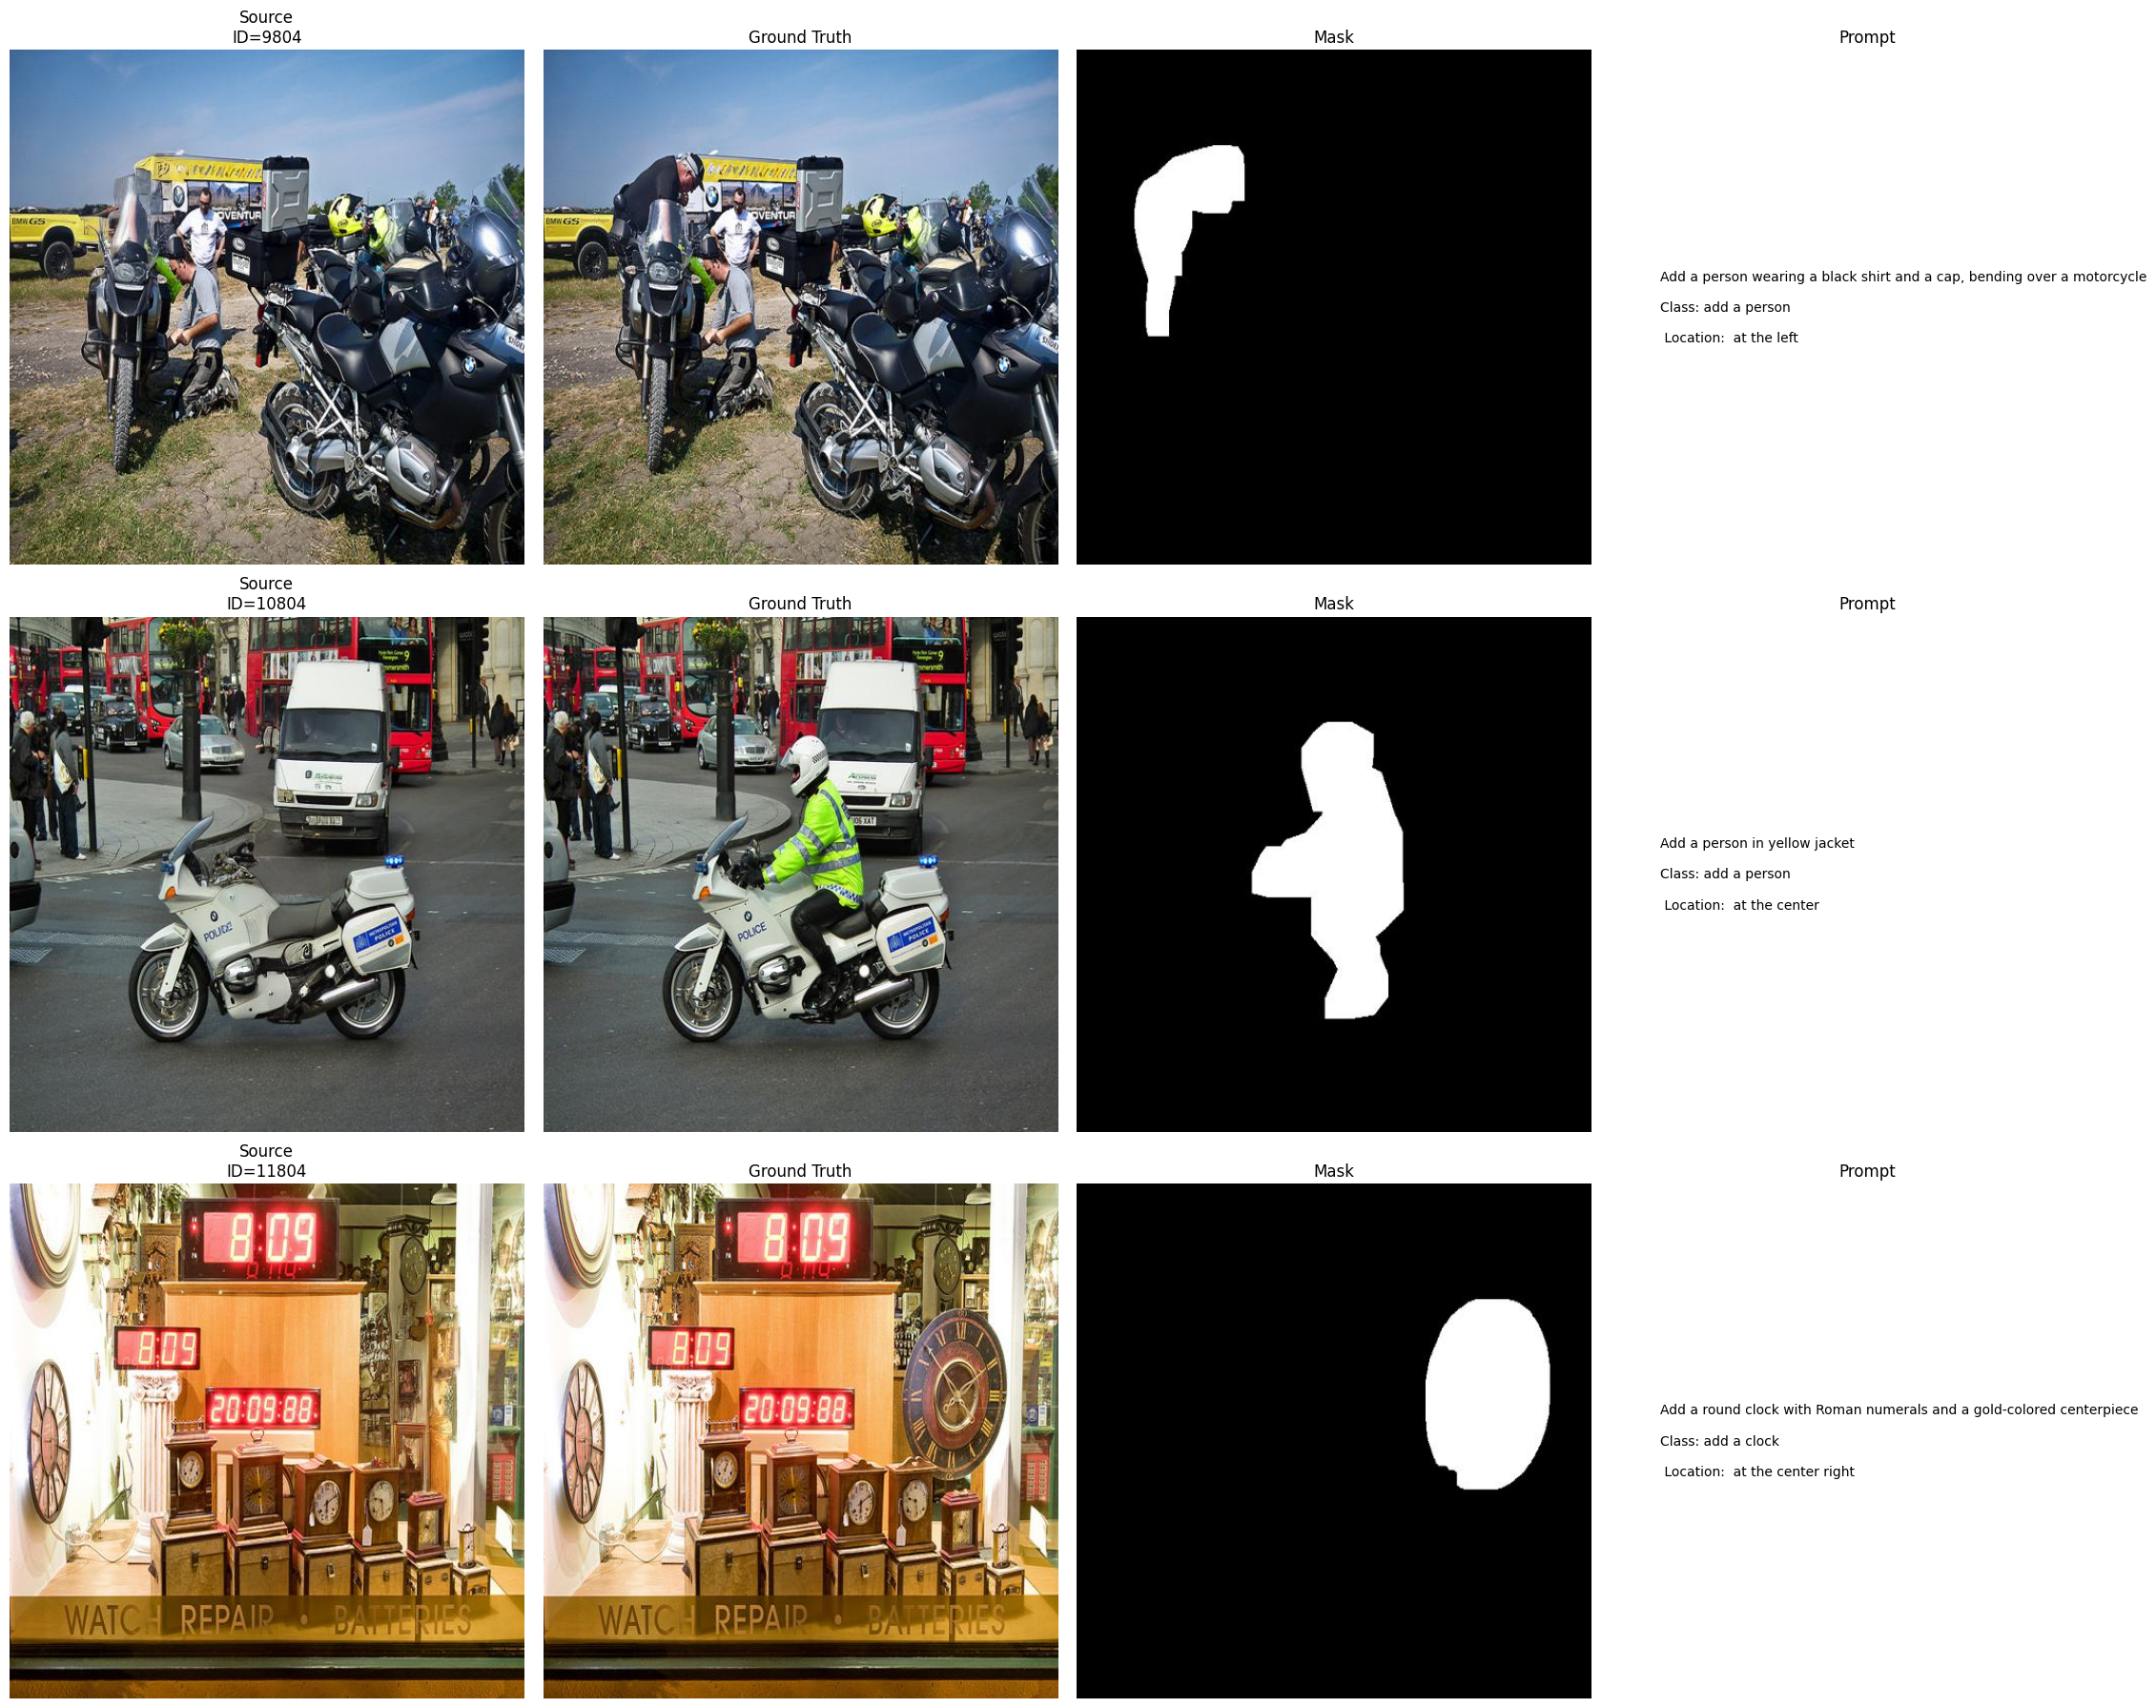

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(24, 6 * 3)) 

if axes.ndim == 1:
    axes_flat = axes
else:
    axes_flat = axes.flatten()

# Iterate over both pipes simultaneously using zip
for i, (sample_data, mask_data) in enumerate(zip(pipe, pipe_masks)):
    if i >= 3: # Break after 3 iterations 
        break

    instruction_vlm_llm = sample_data["Instruction_VLM-LLM"]
    instruction_class = sample_data["Instruction_Class"]
    instruction_location = sample_data["object_location"]
    img = sample_data["source_img"]
    target_img = sample_data["target_img"]
    mask = mask_data["mask"] # Get the mask from pipe_masks

    # Plotting Source Image 
    current_source_ax = axes_flat[i*4]
    current_source_ax.imshow(img)
    current_source_ax.set_title(f"Source\nID={i*1000 + 9804}") # Example ID
    current_source_ax.axis('off') # Hide axes ticks

    # Plotting the Target Image (e.g., Ground Truth) 
    current_target_ax = axes_flat[i*4 + 1]
    current_target_ax.imshow(target_img)
    current_target_ax.set_title(f"Ground Truth")
    current_target_ax.axis('off')

    # Plotting the Mask Image 
    current_mask_ax = axes_flat[i*4 + 2]
    current_mask_ax.imshow(mask, cmap='gray') # Using 'gray' colormap for masks
    current_mask_ax.set_title(f"Mask")
    current_mask_ax.axis('off')

    # Plotting the Prompt 
    current_prompt_ax = axes_flat[i*4 + 3]
    current_prompt_ax.set_title("Prompt")
    current_prompt_ax.axis('off') # Hide axes ticks

    # Display the prompt text in the prompt subplot
    current_prompt_ax.text(0.1, 0.5, f"{instruction_vlm_llm}\n\nClass: {instruction_class}\n\n Location: {instruction_location}",
                           transform=current_prompt_ax.transAxes,
                           ha='left', va='center', fontsize=10, wrap=True)

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show() # Display the plot

In [6]:
for i, (sample_data) in enumerate(pipe):
    if i >= 50: # Break after 3 iterations 
        break

    instruction_vlm_llm = sample_data["Instruction_VLM-LLM"]
    instruction_class = sample_data["Instruction_Class"]
    instruction_location = sample_data["object_location"]
    print("----"*30)
    print(f"Instruction:{instruction_vlm_llm}")
    print(f"Class:{instruction_class}")
    print(f"Location:{instruction_location}")
    

------------------------------------------------------------------------------------------------------------------------
Instruction:Add a person wearing a black shirt and a cap, bending over a motorcycle
Class:add a person
Location: at the left
------------------------------------------------------------------------------------------------------------------------
Instruction:Add a person in yellow jacket
Class:add a person
Location: at the center
------------------------------------------------------------------------------------------------------------------------
Instruction:Add a round clock with Roman numerals and a gold-colored centerpiece
Class:add a clock
Location: at the center right
------------------------------------------------------------------------------------------------------------------------
Instruction:Add a Dalmatian-costumed boy
Class:add a Boy
Location: at the left
--------------------------------------------------------------------------------------------------

---

#### $Dataset$ $Download$ *&* $Preprocessing$

---

Next, we will establish a `dataset` directory with the following subdirectories:

   - `source_images`: Contains the dataset's target images (post-object addition) for object removal input.

   - `target_images`: Contains the dataset's source images (pre-object addition) for inpainting ground truth.

   - `instructions`: Stores prompts derived from merging Class and Location (e.g., "Class at Location").

   - `masks`: Holds binary masks defining object presence and position.



In [ ]:
folder_path = r"/dataset"
os.makedirs(folder_path, exist_ok=True)

In [ ]:
source_images_path = r"/dataset/source_images"
os.makedirs(source_images_path, exist_ok=True)

target_images_path = r"/dataset/target_images"
os.makedirs(target_images_path, exist_ok=True)

instructions_path = r"/dataset/instructions"
os.makedirs(instructions_path, exist_ok=True)

In [10]:
for i, sample in enumerate(pipe):
	instruction_class = sample["Instruction_Class"]
	instruction_location = sample["object_location"]
	merged_instruction = f"{instruction_class}{instruction_location}"
	print(merged_instruction)
	break

add a person at the left


In [20]:
for i, sample in tqdm(enumerate(pipe), total=15000, desc="Processing samples"):

	instruction_class = sample["Instruction_Class"]
	instruction_location = sample["object_location"]
	merged_instruction = f"{instruction_class}{instruction_location}"
	source_img = sample["source_img"]
	target_img = sample["target_img"]
	
	
	# Save the images
	source_img.save(os.path.join(target_images_path, f"target_img_{i}.png"))
	target_img.save(os.path.join(source_images_path, f"source_img_{i}.png"))
	
	# Save the instruction
	with open(os.path.join(instructions_path, f"instruction_{i}.txt"), "w") as f:
		f.write(merged_instruction)
	
	if i == 14999:
		break

Processing samples: 100%|█████████▉| 14999/15000 [01:02<00:00, 240.12it/s]


In [ ]:
masks_path = r"/dataset/masks"
os.makedirs(masks_path, exist_ok=True)

for i, sample in tqdm(enumerate(pipe_masks), total=15000, desc="Processing samples"):
	mask = sample["mask"]
	
	# Save the mask
	mask.save(os.path.join(masks_path, f"mask_{i}.png"))
	
	if i == 14999:
		break

Processing samples: 100%|█████████▉| 14999/15000 [00:35<00:00, 424.93it/s]


For instruction processing, we perform three key transformations:

1. `Prompt Refinement`: Remove the initial "Add a" from prompts. If the resulting instruction is too short (2 words or less), the entry is replaced with a new one from the stream that meets the length requirement.

2. `Whitespace Normalization`: All leading whitespace is removed.

3. `Case Uniformity`: All characters are converted to lowercase.

These steps ensure clean, consistent, and model-ready instructions.

In [ ]:
# 1. Prompt Refinement

# Prepare streaming iterators
pipe_iter = iter(pipe)
pipe_masks_iter = iter(pipe_masks)

# Skip the first 15000 entries (already saved)
for _ in range(15000):
    next(pipe_iter)
    next(pipe_masks_iter)

replacement_offset = 0

for i in range(15000):
    instr_file = os.path.join(instructions_path, f"instruction_{i}.txt")
    
    with open(instr_file, "r") as f:
        content = f.read().split()

    if len(content) > 2:
        # Replace only the first 2 words with 'Delete the'
        content = [''] + content[2:]
        content = ' '.join(content)

        # Save back
        with open(instr_file, "w") as f:
            f.write(content)

    else:
        print(f"File {i} has less than 2 words. Replacing it...")

        # Delete the short-entry files
        os.remove(instr_file)
        os.remove(os.path.join(source_images_path, f"source_img_{i}.png"))
        os.remove(os.path.join(target_images_path, f"target_img_{i}.png"))
        os.remove(os.path.join(masks_path, f"mask_{i}.png"))

        # Fetch replacement until a long-enough prompt is found
        while True:
            sample = next(pipe_iter)
            mask_sample = next(pipe_masks_iter)
            instruction_class = sample["Instruction_Class"]
            instruction_location = sample["object_location"]
            new_instruction = f"{instruction_class}{instruction_location}"
            if len(new_instruction.split()) > 2:
                idx = 15000 + replacement_offset
                replacement_offset += 1

                # Save replacement files using the same `i` index
                sample["target_img"].save(os.path.join(source_images_path, f"source_img_{i}.png"))
                sample["source_img"].save(os.path.join(target_images_path, f"target_img_{i}.png"))
                mask_sample["mask"].save(os.path.join(masks_path, f"mask_{i}.png"))
                
                # Reformat instruction
                new_instruction = ['Delete', 'the'] + new_instruction.split()[2:]
                new_instruction = ' '.join(new_instruction)
                with open(os.path.join(instructions_path, f"instruction_{i}.txt"), "w") as f:
                    f.write(new_instruction)
                
                print(f"Replaced entry {i} with new data from index {idx}.")
                break

File 627 has less than 2 words. Replacing it...
Replaced entry 627 with new data from index 15000.
File 2934 has less than 2 words. Replacing it...
Replaced entry 2934 with new data from index 15001.
File 5534 has less than 2 words. Replacing it...
Replaced entry 5534 with new data from index 15002.
File 5931 has less than 2 words. Replacing it...
Replaced entry 5931 with new data from index 15003.
File 11689 has less than 2 words. Replacing it...
Replaced entry 11689 with new data from index 15004.
File 11936 has less than 2 words. Replacing it...
Replaced entry 11936 with new data from index 15005.
File 13329 has less than 2 words. Replacing it...
Replaced entry 13329 with new data from index 15006.


In [ ]:
# 2. Whitespace Normalization and 3. Case Uniformity

for i in range(15000): 
    instr_file_path = os.path.join(instructions_path, f"instruction_{i}.txt")
    if os.path.exists(instr_file_path):
        try:
            # Read the current content of the instruction file
            with open(instr_file_path, "r") as f:
                original_content = f.read()

            # Convert to lowercase and remove leading/trailing whitespace
            cleaned_content = original_content.lower().strip()

            # Write the cleaned content back to the same file
            with open(instr_file_path, "w") as f:
                f.write(cleaned_content)

            if i % 1000 == 0:
                print(f"Processed instruction file {i}: '{original_content.strip()}' -> '{cleaned_content}'")

        except Exception as e:
            print(f"Error processing file {instr_file_path}: {e}")
    else:
        print(f"File {instr_file_path} not found, skipping.") 
   

print("Post-processing complete for all instruction files.")


Processed instruction file 0: 'person at the left' -> 'person at the left'
Processed instruction file 1000: 'Woman at the top left' -> 'woman at the top left'
Processed instruction file 2000: 'Man at the center left' -> 'man at the center left'
Processed instruction file 3000: 'Laptop at the top right' -> 'laptop at the top right'
Processed instruction file 4000: 'Person at the center left' -> 'person at the center left'
Processed instruction file 5000: 'Luggage and bags at the bottom right' -> 'luggage and bags at the bottom right'
Processed instruction file 6000: 'Flower at the bottom right' -> 'flower at the bottom right'
Processed instruction file 7000: 'Skyscraper at the top left' -> 'skyscraper at the top left'
Processed instruction file 8000: 'Coffee cup at the center' -> 'coffee cup at the center'
Processed instruction file 9000: 'person at the right' -> 'person at the right'
Processed instruction file 10000: 'Car at the center right' -> 'car at the center right'
Processed inst

---

#### $Dataset$ $Sample$ $Display$

---

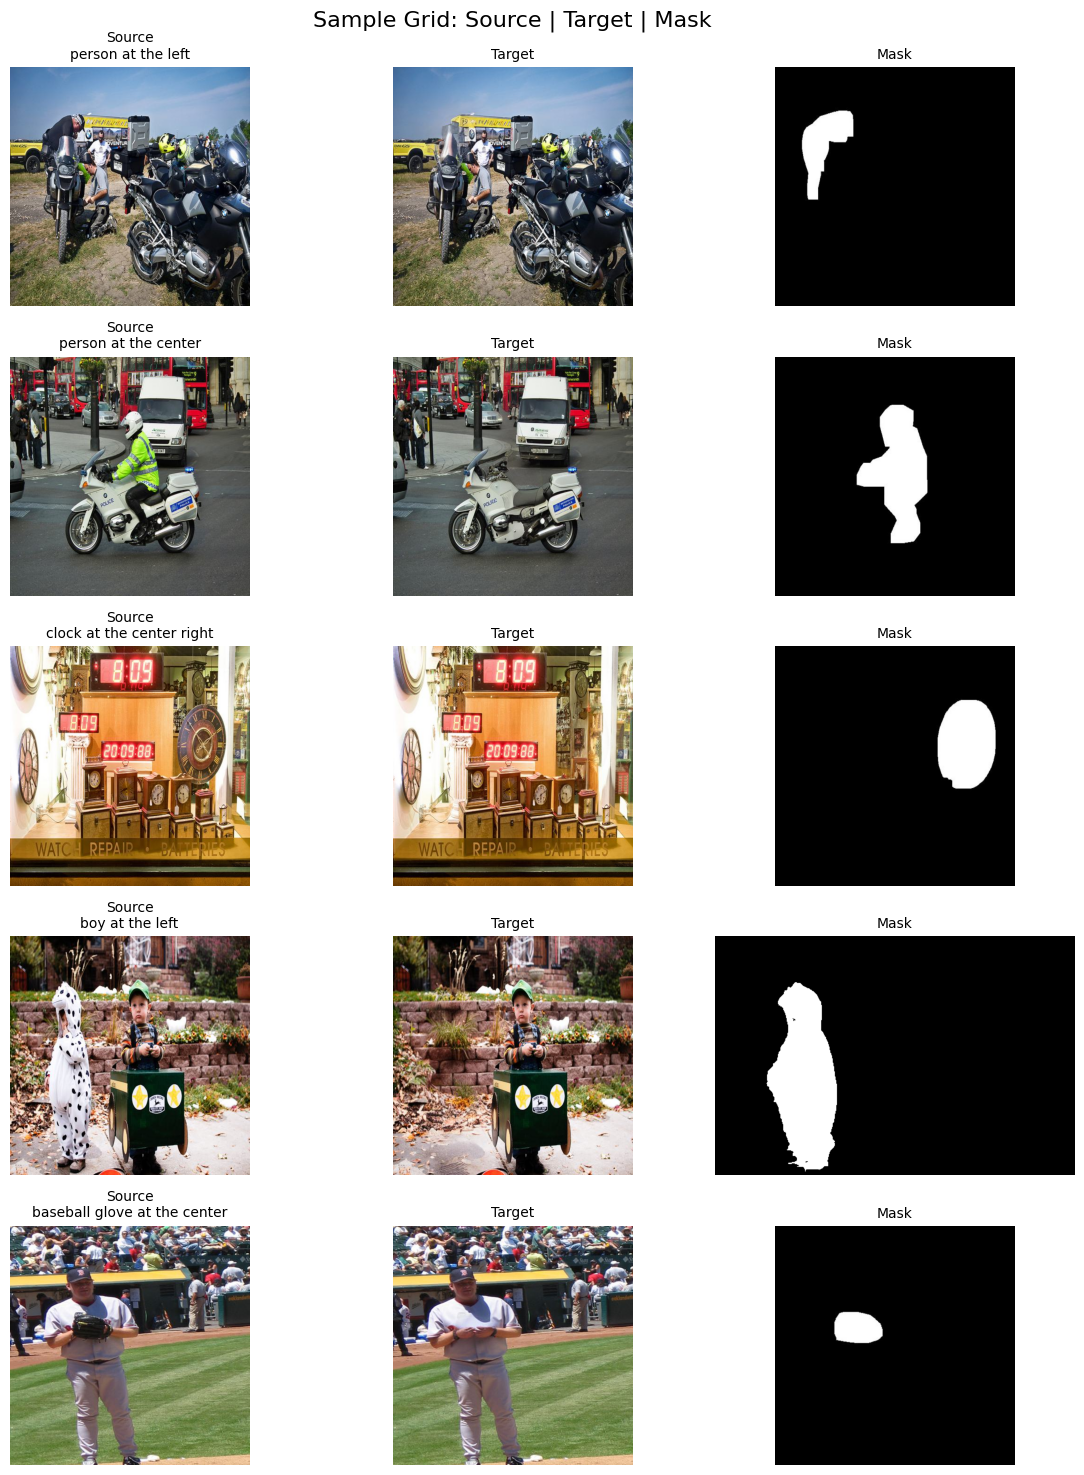

In [23]:
# Number of samples to display
n_samples = 5

# Set up a grid: rows = samples, columns = [source, target, mask]
fig, axes = plt.subplots(n_samples, 3, figsize=(12, 3 * n_samples))
fig.suptitle("Sample Grid: Source | Target | Mask", fontsize=16)

for i in range(n_samples):
    # Load images
    source_img = Image.open(os.path.join(source_images_path, f"source_img_{i}.png"))
    target_img = Image.open(os.path.join(target_images_path, f"target_img_{i}.png"))
    
    # Load mask. Ensure it's converted to 'L' mode (8-bit pixels, grayscale) if not already.
    mask_img = Image.open(os.path.join(masks_path, f"mask_{i}.png")).convert('L')

    # Load instruction
    with open(os.path.join(instructions_path, f"instruction_{i}.txt"), "r") as f:
        instruction = f.read().strip() # Added .strip() just in case for display

    # Plot source
    axes[i, 0].imshow(source_img)
    axes[i, 0].set_title(f"Source\n{instruction}", fontsize=10)
    axes[i, 0].axis("off")

    # Plot target
    axes[i, 1].imshow(target_img)
    axes[i, 1].set_title("Target", fontsize=10)
    axes[i, 1].axis("off")

    # Plot mask with a grayscale colormap to force black and white
    axes[i, 2].imshow(mask_img, cmap='gray') 
    axes[i, 2].set_title("Mask", fontsize=10)
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

---

#### $Train$ - $Dev$ - $Test$ $Set$ $Split$

---

After the initial data preprocessing and instruction cleaning, the next step is to organize the dataset into standard training, validation, and testing splits.
We create subfolders within the main dataset directory for each split (train, val, test) and for each data modality (source_images, target_images, masks, instructions). The data is then split as follows:

* `Train Set`: 75% of the data, used for model training.

* `Validation Set`: 15% of the data, used for hyperparameter tuning and monitoring model performance.

* `Test Set`: 10% of the data, reserved for final, unbiased evaluation.


In [ ]:
base = "/dataset"

# Splits and sub-folders to create
splits = ["train", "val", "test"]
subdirs = ["source_images", "target_images", "masks", "instructions"]

# Create the folder structure
for split in splits:
    for sub in subdirs:
        path = os.path.join(base, split, sub)
        os.makedirs(path, exist_ok=True)

# Quick sanity check
print("Created folders:")
for split in splits:
    for sub in subdirs:
        p = os.path.join(base, split, sub)
        print(f"  {split}/{sub}  →  {'Exists!' if os.path.isdir(p) else 'Something went wrong!'}")


Created folders:
  train/source_images  →  Exists!
  train/target_images  →  Exists!
  train/masks  →  Exists!
  train/instructions  →  Exists!
  val/source_images  →  Exists!
  val/target_images  →  Exists!
  val/masks  →  Exists!
  val/instructions  →  Exists!
  test/source_images  →  Exists!
  test/target_images  →  Exists!
  test/masks  →  Exists!
  test/instructions  →  Exists!


In [ ]:
orig = {
    'source':       os.path.join(base, "source_images"),
    'target':       os.path.join(base, "target_images"),
    'masks':        os.path.join(base, "masks"),
    'instructions': os.path.join(base, "instructions")
}

# Gather IDs
all_ids = sorted([
    fname.split('_')[-1].split('.')[0]
    for fname in os.listdir(orig['source'])
    if fname.startswith("source_img_")
])

In [27]:
# Split 75% train, 15% val, 10% test
train_ids, temp_ids = train_test_split(all_ids, test_size=0.25,  random_state=42)
val_ids,   test_ids = train_test_split(temp_ids,  test_size=0.4,  random_state=42)
splits = {"train": train_ids, "val": val_ids, "test": test_ids}


`File Relocation`: Each individual file (source image, target image, mask, and instruction) is moved from its initial flat directory into its newly created, split-specific subdirectory, e.g.:
 - *source_img_1.png* : dataset/source_images -> dataset/train/source_images/source_img_1.png 

This ensures that each complete sample resides within its designated split.

In [ ]:
subdirs = {
    'source':       "source_images",
    'target':       "target_images",
    'masks':        "masks",
    'instructions': "instructions"
}

# Move files
for split, ids in splits.items():
    for idx in ids:
        # Build and move each modality
        # 1) source image
        src = os.path.join(orig['source'], f"source_img_{idx}.png")
        dst = os.path.join(base, split, subdirs['source'], f"source_img_{idx}.png")
        shutil.move(src, dst)

        # 2) target image
        src = os.path.join(orig['target'], f"target_img_{idx}.png")
        dst = os.path.join(base, split, subdirs['target'], f"target_img_{idx}.png")
        shutil.move(src, dst)

        # 3) mask
        src = os.path.join(orig['masks'], f"mask_{idx}.png")
        dst = os.path.join(base, split, subdirs['masks'], f"mask_{idx}.png")
        shutil.move(src, dst)

        # 4) instruction
        src = os.path.join(orig['instructions'], f"instruction_{idx}.txt")
        dst = os.path.join(base, split, subdirs['instructions'], f"instruction_{idx}.txt")
        shutil.move(src, dst)

`Cleanup:` After all files are relocated, the original, now empty, directories are removed.

In [ ]:
# delete empty original directories
for folder in orig.values():
    if os.path.isdir(folder) and not os.listdir(folder):
        os.rmdir(folder)

In [31]:
# Verify counts
for split in splits:
    n = len(os.listdir(os.path.join(base, split, "source_images")))
    print(f"{split}: {n} samples")

train: 11250 samples
val: 2250 samples
test: 1500 samples


---

#### $Final$ $Folder$ $Structure$

---


```{}
/dataset/
├── train/
│   ├── source_images/
│   ├── target_images/
│   ├── masks/
│   └── instructions/
├── val/
│   ├── source_images/
│   ├── target_images/
│   ├── masks/
│   └── instructions/
└── test/
    ├── source_images/
    ├── target_images/
    ├── masks/
    └── instructions/
```